In [14]:
from desitarget.targetmask import desi_mask
from desitarget.sv1 import sv1_targetmask
from desitarget.sv2 import sv2_targetmask
from desitarget.sv3 import sv3_targetmask
sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask
from desispec.coaddition import coadd_cameras
import desispec.io

from astropy.table import Table, join
from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc

import pickle
from IPython.display import clear_output

In [2]:
with fits.open("/global/cfs/cdirs/desi/public/edr/vac/edr/fastspecfit/fuji/v3.2/catalogs/fastspec-fuji.fits", memmap = True) as hdul:
    is_elg = (hdul[2].data["SV1_DESI_TARGET"] & sv1_desi_mask['ELG'] != 0)|(hdul[2].data["SV2_DESI_TARGET"] & sv2_desi_mask['ELG'] != 0)|(hdul[2].data["SV3_DESI_TARGET"] & sv3_desi_mask['ELG'] != 0)
    ELG1 = Table(hdul[1].data[is_elg])
    ELG2 = Table(hdul[2].data[is_elg])
    ELG = join(ELG1, ELG2, keys = 'TARGETID', join_type='left')

In [91]:
def my_selection(ELG = ELG, redshift_range_OII = [0.1, 0.4], OII_SNR = 4, OIII_SNR = [5, 7], HALPHA_SNR = [5, 7], redshift_range_Lya = [1.96, 7.08], Lya_SNR = 5, CIV_SNR = [2, 5]):
    def BOX_SNR(dataset, feature):
        signal = dataset[str(feature) + "_BOXFLUX"]
        noise = dataset[str(feature) + "_BOXFLUX_IVAR"]
        preSNR = signal / noise ** (-1 / 2)
        return np.nan_to_num(preSNR)

    mask_redshift_low = ELG["Z_1"] < redshift_range_Lya[1]
    mask_redshift_high = ELG["Z_1"] > redshift_range_Lya[0]
    selection1 = ELG[mask_redshift_low & mask_redshift_high]
    selection1 = selection1[BOX_SNR(selection1, "CIV_1549") > CIV_SNR[0]]
    selection1 = selection1[BOX_SNR(selection1, "CIV_1549") < CIV_SNR[1]]
    selection1 = selection1[BOX_SNR(selection1, "LYALPHA") > Lya_SNR]
    selection1 = selection1[selection1["LYALPHA_NPIX"] < 60]

    mask_redshift_low = ELG["Z_1"] < redshift_range_OII[1]
    mask_redshift_high = ELG["Z_1"] > redshift_range_OII[0]
    selection2 = ELG[mask_redshift_low & mask_redshift_high] 
    selection2 = selection2[BOX_SNR(selection2, "OII_3726") > OII_SNR]
    selection2 = selection2[BOX_SNR(selection2, "OIII_5007") > OIII_SNR[0]]
    selection2 = selection2[BOX_SNR(selection2, "OIII_5007") < OIII_SNR[1]]
    selection2 = selection2[BOX_SNR(selection2, "HALPHA") > HALPHA_SNR[0]]
    selection2 = selection2[BOX_SNR(selection2, "HALPHA") < HALPHA_SNR[1]]
    
    return selection1, selection2

In [92]:
selection1, selection2 = my_selection()

/tmp/ipykernel_968809/400385732.py:5: RuntimeWarning: divide by zero encountered in power
  preSNR = signal / noise ** (-1 / 2)


In [93]:
len(selection2)

132

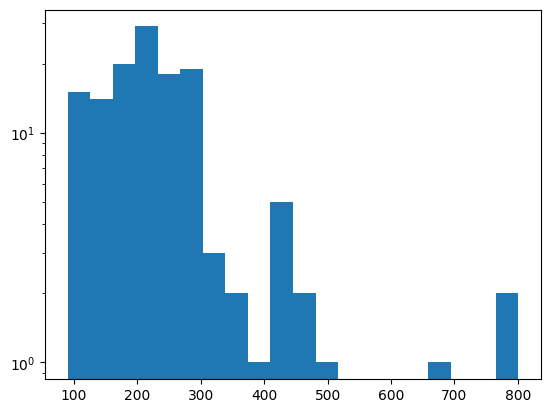

In [96]:
plt.hist(selection2["DELTACHI2"], bins = 20)
plt.yscale("log")
# plt.xlim(0, 2500)